In [89]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys, os

height = 64
width = 64
image0 = np.zeros((height, width), dtype=np.uint8) 

def computehoughTransformCoord(x1, y1, x2, y2):

    if x1 == x2:
        return(np.pi/2, abs(y1-y2), abs(x1))

    k =  (y1 - y2) / (x1 - x2)
    theta = np.arctan(-k)

    A = y2 - y1
    B = x2 - x1
    C = abs(x2*y1 - x1*y2)
    length = np.sqrt(A**2 + B**2)
    rho = abs(C / length)
    
    return np.degrees(theta), length, rho

def simulateSigma(image0, noise_std, low, high, iterNum = 2000, draw = False):

    height, width = image0.shape
    bound = int(width / 2)

    # thetaT = 45
    # rhoT = height/np.sqrt(2)-0.5

    # for i in range(0, height):
    #     image0[i, 0: height-i] = low
    #     image0[i, height-i : height] = high

    image0[0:bound, :] = high
    image0[bound:, :] = low

    thetaT = 0
    rhoT = 31.5

    lsd = cv2.createLineSegmentDetector(0)
    thetaList = []
    rhoList = []

    for _ in range(0, iterNum):
        image = image0 + np.round(np.random.normal(0, noise_std, image0.shape)).astype(int)
        image = np.uint8(image)

        if draw == True:
            cv2.imwrite("blur_image.png", image)

        lines, width, prec, nfa = lsd.detect(image)

        drawn_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        if lines is None:
            print("================empty lines==============")
        else:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                theta, length, rho = computehoughTransformCoord(x1, y1, x2, y2)

                if abs( rho - rhoT ) > 3 or abs(theta - thetaT) > 7:
                    continue

                thetaList.append(theta)
                rhoList.append(rho)

                if draw == True:
                    x1, y1, x2, y2 = map(int, line[0])
                    drawn_img = cv2.line(drawn_img, (x1, y1), (x2, y2), (0, 255, 0), 1, cv2.LINE_AA)

                # print(f"theta : {theta - thetaT}, rho : {rho - rhoT}")
            if draw == True:
                cv2.imwrite("drawn_img.png", drawn_img)

    thetaList = np.asarray(thetaList)
    rhoList = np.asarray(rhoList)
    thetaSigma = np.std(thetaList)
    rhoSigma = np.std(rhoList)
    # print(np.mean(rhoList))
    # print(thetaSigma, rhoSigma)
    return thetaSigma, rhoSigma

# Error_std-Noise_std

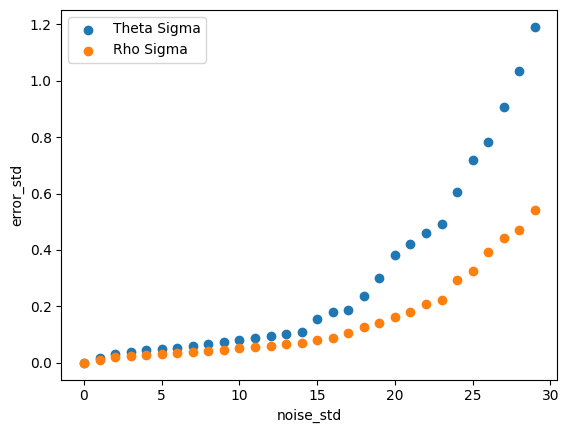

In [90]:
thetaSigmaList = []
rhoSigmaList = []
high = 180
low = 70
start = 0
end = 30
noiseList = range(0, 30)

# 检查当前文件夹中是否存在Results路径
if not os.path.exists("Results"):
    os.makedirs("Results")

for noise in noiseList:
    # print(f"===========noise {noise}==========")
    thetaSigma, rhoSigma = simulateSigma(image0, noise, 70, 180, iterNum=5000)
    thetaSigmaList.append(thetaSigma)
    rhoSigmaList.append(rhoSigma)

# 将三个list转换为NumPy数组
noiseList = np.array(noiseList)
thetaSigmaList = np.array(thetaSigmaList)
rhoSigmaList = np.array(rhoSigmaList)

# 保存为.npy文件
np.save(f'Results/Noise_start{start}_end{end}_high{high}_low{low}.npy', [noiseList, thetaSigmaList, rhoSigmaList])

plt.figure()
plt.scatter(noiseList, thetaSigmaList, label='Theta Sigma')
plt.scatter(noiseList, rhoSigmaList, label='Rho Sigma')
plt.xlabel("noise_std")
plt.ylabel("error_std")
plt.legend()
plt.savefig(f"Results/Noise_start{start}_end{end}_high{high}_low{low}.png")

# Error_std-Delta

================empty lines==============
================empty lines==============
================empty lines==============
================empty lines==============


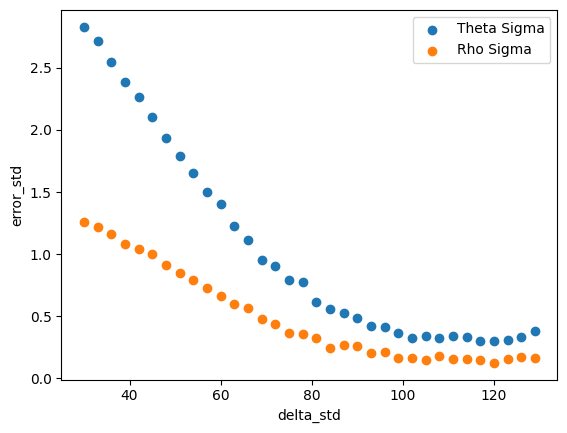

In [91]:
thetaSigmaList = []
rhoSigmaList = []
noise = 20
low = 70
start = 30
end = 130
step = 3
deltaList = range(start, end, step)

# 检查当前文件夹中是否存在Results路径
if not os.path.exists("Results"):
    os.makedirs("Results")

for delta in deltaList:
    # print(f"===========delta {delta}==========")
    thetaSigma, rhoSigma = simulateSigma(image0, noise, low, low + delta, iterNum=4000)
    thetaSigmaList.append(thetaSigma)
    rhoSigmaList.append(rhoSigma)

# 将三个list转换为NumPy数组
deltaList = np.array(deltaList)
thetaSigmaList = np.array(thetaSigmaList)
rhoSigmaList = np.array(rhoSigmaList)

# 保存为.npy文件
np.save(f'Results/Delta_start{start}_end{end}_noise{noise}_low{low}.npy', [deltaList, thetaSigmaList, rhoSigmaList])

plt.figure()
plt.scatter(deltaList, thetaSigmaList, label='Theta Sigma')
plt.scatter(deltaList, rhoSigmaList, label='Rho Sigma')
plt.xlabel("delta_std")
plt.ylabel("error_std")
plt.legend()
plt.savefig(f"Results/Delta_start{start}_end{end}_noise{noise}_low{low}.png")

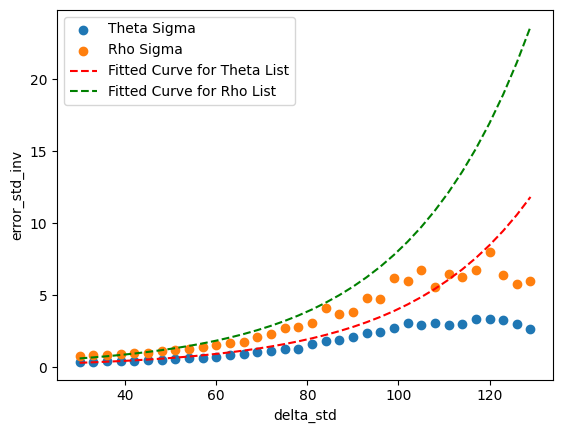

In [92]:
deltaList, thetaSigmaList, rhoSigmaList = np.load("Results/Delta_start{start}_end{end}_noise{noise}_low{low}.npy")
thetaSigmaList = 1 / thetaSigmaList
rhoSigmaList = 1 / rhoSigmaList
def func(x, a, b, c):
    return a + b * np.exp(c * x)

plt.figure()
plt.scatter(deltaList, thetaSigmaList, label='Theta Sigma')
plt.scatter(deltaList, rhoSigmaList, label='Rho Sigma')
plt.xlabel("delta_std")
plt.ylabel("error_std_inv")
plt.plot(deltaList, func(deltaList, 0, 0.1, 0.037), 'r--', label='Fitted Curve for Theta List')
plt.plot(deltaList, func(deltaList, 0, 0.2, 0.037), 'g--', label='Fitted Curve for Rho List')
plt.legend()

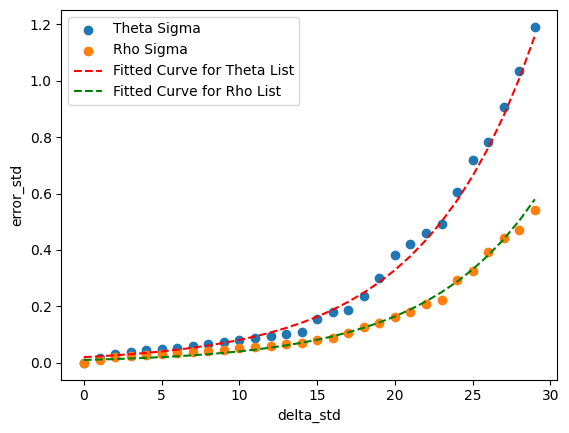

In [101]:
deltaList, thetaSigmaList, rhoSigmaList = np.load("Results/Noise_start{start}_end{end}_high{high}_low{low}.npy")
def func(x, a, b, c):
    return a + b * np.exp(c * x)

plt.figure()
plt.scatter(deltaList, thetaSigmaList, label='Theta Sigma')
plt.scatter(deltaList, rhoSigmaList, label='Rho Sigma')
plt.xlabel("delta_std")
plt.ylabel("error_std")
plt.plot(deltaList, func(deltaList, 0, 0.02, 0.14), 'r--', label='Fitted Curve for Theta List')
plt.plot(deltaList, func(deltaList, 0, 0.01, 0.14), 'g--', label='Fitted Curve for Rho List')
plt.legend()